In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import mne
from mne.preprocessing import ICA, create_eog_epochs
from mne import io, combine_evoked
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.datasets import spm_face  # sample data
from glob import glob
import re
import yaml
from mne.preprocessing import ICA, read_ica
from mne.channels import make_standard_montage

print(__doc__)


Automatically created module for IPython interactive environment


Extracting parameters from /Volumes/lu32pog/Nan_ssvep/EEG data and analysis/Rawdata_exp1/QiuLiesefeld_SSVEP_0001.vhdr...
Setting channel info structure...
Reading 0 ... 6656639  =      0.000 ...  6656.639 secs...


/var/folders/l_/l_cqmr9n1f19wzndp8cbwl580000gn/T/ipykernel_996/533310936.py:4: RuntimeWarning: Not setting positions of 3 eog channels found in montage:
['LO1', 'LO2', 'IO2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(FILES,eog=('LO1', 'LO2', 'IO2'), misc='auto', scale=1.0, preload=True, verbose=None)


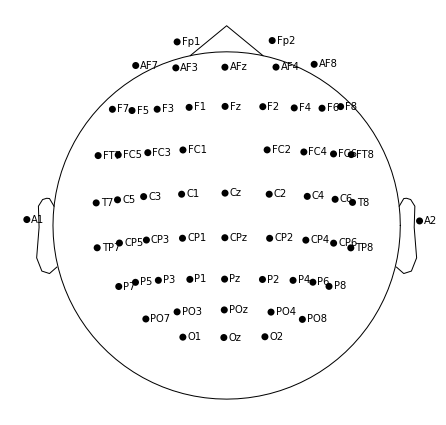

Used Annotations descriptions: ['Comment/no USB Connection to actiCAP', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  4', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 45', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 52', 'Stimulus/S 62', 'Stimulus/S 63', 'Stimulus/S 65', 'Stimulus/S 66', 'Stimulus/S 79', 'Stimulus/S 80', 'Stimulus/S 82', 'Stimulus/S 83', 'Stimulus/S 93', 'Stimulus/S 96', 'Stimulus/S 97', 'Stimulus/S 98', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S150', 'Stimulus/S151', 'Stimulus/S152', 'Stimulus/S153', 'Stimulus/S200', 'Stimulus/S240', 'Stimulus/S241', 'Stimulus/S242', 'Stimulus/S244']
<RawBrainVision | QiuLiesefeld_SSVEP_0001.eeg, 64 x 6656640 (6656.6 s), ~3.17 GB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, LO1, FC5, FC1, C3, T7, A1, CP5, CP1, Pz, P3, ...
 chs: 61 EEG, 3 EOG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal,

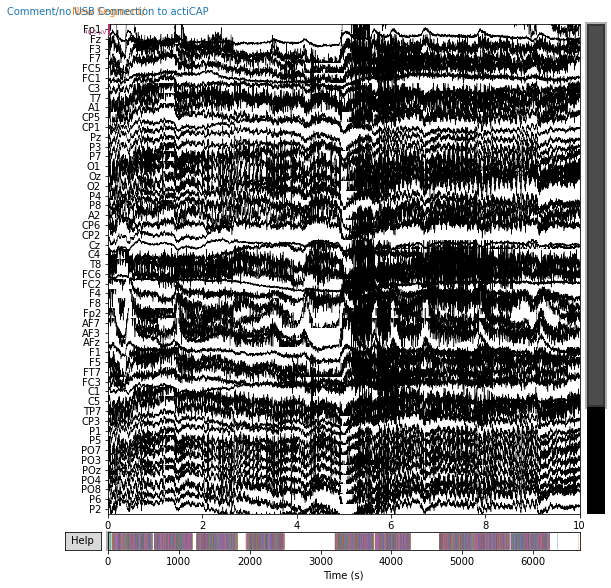

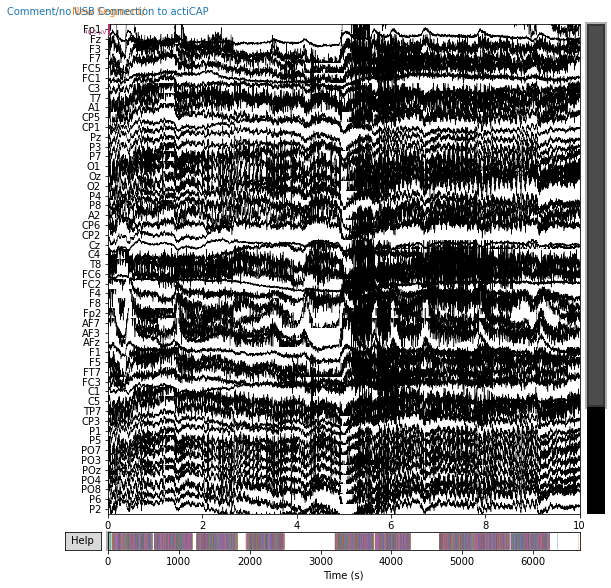

In [6]:
#load data
raw_file = "/Volumes/lu32pog/Nan_ssvep/EEG data and analysis/Rawdata_exp1/QiuLiesefeld_SSVEP_0001.vhdr"

raw = mne.io.read_raw_brainvision(raw_file,eog=('LO1', 'LO2', 'IO2'), misc='auto', scale=1.0, preload=True, verbose=None)
montage = make_standard_montage('standard_1020')
raw.set_montage(montage)
raw.set_channel_types({'LO1': 'eog', 'LO2': 'eog', 'IO2': 'eog'})

fig = raw.plot_sensors(show_names=True)
events = mne.events_from_annotations(raw)
print(raw)
print(raw.info)
raw.plot(n_channels=50)


Load and filter data, set up epochs. 


In [12]:
print(all_event_id)
print(all_events)

{'Comment/no USB Connection to actiCAP': 10001, 'New Segment/': 99999, 'Stimulus/S  1': 1, 'Stimulus/S  4': 4, 'Stimulus/S 14': 14, 'Stimulus/S 15': 15, 'Stimulus/S 17': 17, 'Stimulus/S 18': 18, 'Stimulus/S 31': 31, 'Stimulus/S 32': 32, 'Stimulus/S 34': 34, 'Stimulus/S 35': 35, 'Stimulus/S 45': 45, 'Stimulus/S 48': 48, 'Stimulus/S 49': 49, 'Stimulus/S 52': 52, 'Stimulus/S 62': 62, 'Stimulus/S 63': 63, 'Stimulus/S 65': 65, 'Stimulus/S 66': 66, 'Stimulus/S 79': 79, 'Stimulus/S 80': 80, 'Stimulus/S 82': 82, 'Stimulus/S 83': 83, 'Stimulus/S 93': 93, 'Stimulus/S 96': 96, 'Stimulus/S 97': 97, 'Stimulus/S 98': 98, 'Stimulus/S103': 103, 'Stimulus/S104': 104, 'Stimulus/S150': 150, 'Stimulus/S151': 151, 'Stimulus/S152': 152, 'Stimulus/S153': 153, 'Stimulus/S200': 200, 'Stimulus/S240': 240, 'Stimulus/S241': 241, 'Stimulus/S242': 242, 'Stimulus/S244': 244}
[[      0       0   99999]
 [      0       0   10001]
 [   6498       0     244]
 ...
 [1557592       0     153]
 [1585151       0     241]
 [1

In [14]:
#resample
raw.resample(250, npad='auto')
#re-reference
raw.set_eeg_reference(['A1', 'A2'])
picks = mne.pick_types(raw.info, eeg=True, eog=False, stim=True, meg=True,exclude='bads')
raw.filter(0.1, 40, method='fir', fir_design='firwin')

##epochs
all_events, all_event_id = mne.events_from_annotations(raw)
# sample_data_folder = mne.datasets.sample.data_path()
# sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif')

tmin = -0.2
tmax = 4

metadata, events, event_id = mne.epochs.make_metadata(events=all_events, event_id=all_event_id, tmin=tmin, tmax=tmax, sfreq=raw.info['sfreq'] ,
                            row_events= ['Stimulus/S  4','Stimulus/S 31','Stimulus/S 34','Stimulus/S  1', 'Stimulus/S 32','Stimulus/S 35']) 
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax,metadata=metadata, baseline=None, preload=True)
epochs.metadata
print(epochs)
print(event_id)
# print(epochs.metadata)
epochs.metadata
# # set up and fit the ICA
# ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
# ica.fit(raw)
# ica.exclude = [1, 2]  # details on how we picked these are omitted here
# ica.plot_properties(raw, picks=ica.exclude)

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 8251 samples (33.004 sec)

Used Annotations descriptions: ['Comment/no USB Connection to actiCAP', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  4', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 45', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 52', 'Stimulus/S 62', 'Stimul

,event_name,Comment/no USB Connection to actiCAP,New Segment/,Stimulus/S 1,Stimulus/S 4,Stimulus/S 14,Stimulus/S 15,Stimulus/S 17,Stimulus/S 18,Stimulus/S 31,...,Stimulus/S104,Stimulus/S150,Stimulus/S151,Stimulus/S152,Stimulus/S153,Stimulus/S200,Stimulus/S240,Stimulus/S241,Stimulus/S242,Stimulus/S244
0,Stimulus/S 35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.264,2.324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Stimulus/S 4,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.424,3.808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Stimulus/S 4,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.420,2.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Stimulus/S 4,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.592,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN
4,Stimulus/S 32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.376,3.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Stimulus/S 34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.348,2.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,Stimulus/S 1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.216,2.332,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,Stimulus/S 1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.224,3.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,Stimulus/S 31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,1.592,3.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ds directory : /root/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.90   72.01    0.00 mm <->   -0.90   72.01    0.00 mm (orig :  -43.09   61.46 -252.17 mm) diff =    0.000 mm
       0.90  -72.01    0.00 mm <->    0.90  -72.01    0.00 mm (orig :   53.49  -45.24 -258.02 mm) diff =    0.000 mm
      98.30    0.00    0.00 mm <->   98.30   -0.00    0.00 mm (orig :   78.60   72.16 -241.87 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /root/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds/SPM_CTF_MEG_example_faces1_3D.meg4: 
    System clock channel is available, checking which samples are valid.
    1 x 324474 = 324474 samples from 340 chs
Current compen

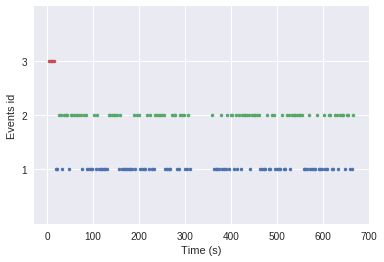

168 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 168 events and 97 original time points ...
    Rejecting  epoch based on MAG : ['MLT35-2908', 'MLT42-2908', 'MLT45-2908', 'MLT52-2908', 'MRT14-2908', 'MRT43-2908', 'MRT44-2908', 'MRT45-2908', 'MRT53-2908', 'MRT54-2908']
    Rejecting  epoch based on MAG : ['MLT35-2908', 'MLT42-2908', 'MLT45-2908', 'MLT52-2908', 'MRT14-2908', 'MRT43-2908', 'MRT44-2908', 'MRT45-2908', 'MRT53-2908', 'MRT54-2908']
    Rejecting  epoch based on MAG : ['MLT35-2908', 'MLT42-2908', 'MLT45-2908', 'MLT52-2908', 'MRT14-2908', 'MRT43-2908', 'MRT44-2908', 'MRT45-2908', 'MRT53-2908', 'MRT54-2908']
    Rejecting  epoch based on MAG : ['MLT35-2908', 'MLT42-2908', 'MLT45-2908', 'MLT52-2908', 'MRT14-2908', 'MRT43-2908', 'MRT44-2908', 'MRT45-2908', 'MRT53-2908', 'MRT54-2908']
    Rejecting  epoch based on MAG : ['MRT43-2908']
5 bad epochs dropped
Fitting ICA to data using 274 channels (please be pat

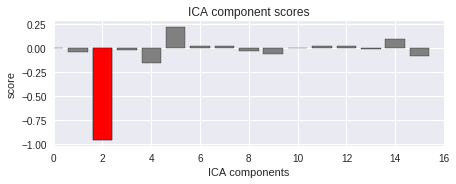

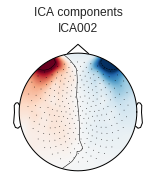

Transforming to ICA space (16 components)
Zeroing out 1 ICA components


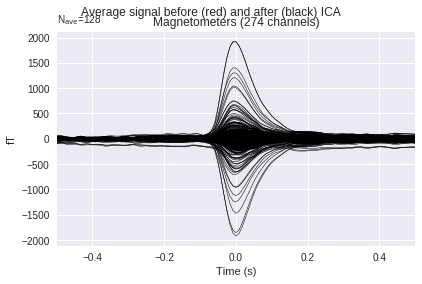

Transforming to ICA space (16 components)
Zeroing out 1 ICA components


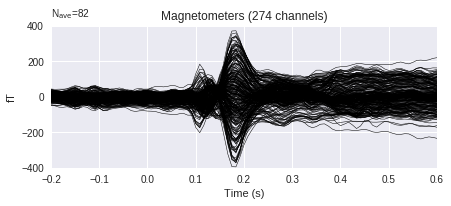

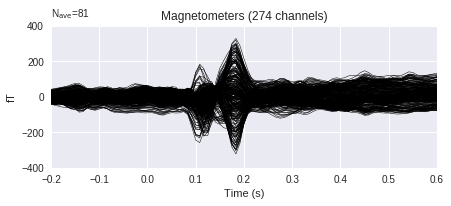

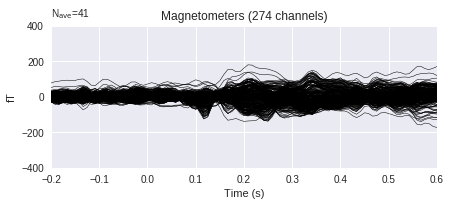

Removing 5 compensators from info because not all compensation channels were picked.


<ipython-input-10-95e6d389b07e>:50: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  rank=None)


estimated rank (mag): 274
Setting small MAG eigenvalues to zero.
Not doing PCA for MAG.
Reducing data rank from 274 -> 274
Estimating covariance using SHRUNK
Done.
Number of samples used : 4075
[done]


In [ ]:
raw_fname = data_path + '/MEG/spm/SPM_CTF_MEG_example_faces%d_3D.ds'

raw = io.read_raw_ctf(raw_fname % 1, preload=True)  # Take first run
# Here to save memory and time we'll downsample heavily -- this is not
# advised for real data as it can effectively jitter events!
raw.resample(120., npad='auto')

picks = mne.pick_types(raw.info, meg=True, exclude='bads')
raw.filter(0.1, 30, method='fir', fir_design='firwin')

events = mne.find_events(raw, stim_channel='UPPT001')

# plot the events to get an idea of the paradigm
mne.viz.plot_events(events, raw.info['sfreq'])

event_ids = {"faces": 1, "scrambled": 2}

tmin, tmax = -0.2, 0.6
baseline = None  # no baseline as high-pass is applied
reject = dict(mag=5e-12)

epochs = mne.Epochs(raw, events, event_ids, tmin, tmax,  picks=picks,
                    baseline=baseline, preload=True, reject=reject)

# Fit ICA, find and remove major artifacts
ica = ICA(n_components=0.95, random_state=0).fit(raw, decim=1, reject=reject)

# compute correlation scores, get bad indices sorted by score
eog_epochs = create_eog_epochs(raw, ch_name='MRT31-2908', reject=reject)
eog_inds, eog_scores = ica.find_bads_eog(eog_epochs, ch_name='MRT31-2908')
ica.plot_scores(eog_scores, eog_inds)  # see scores the selection is based on
ica.plot_components(eog_inds)  # view topographic sensitivity of components
ica.exclude += eog_inds[:1]  # we saw the 2nd ECG component looked too dipolar
ica.plot_overlay(eog_epochs.average())  # inspect artifact removal
ica.apply(epochs)  # clean data, default in place

evoked = [epochs[k].average() for k in event_ids]

contrast = combine_evoked(evoked, weights=[-1, 1])  # Faces - scrambled

evoked.append(contrast)

for e in evoked:
    e.plot(ylim=dict(mag=[-400, 400]))

plt.show()

# estimate noise covarariance
noise_cov = mne.compute_covariance(epochs, tmax=0, method='shrunk',
                                   rank=None)


In [ ]:
[k for k in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Visualize fields on MEG helmet




In [ ]:
# The transformation here was aligned using the dig-montage. It's included in
# the spm_faces dataset and is named SPM_dig_montage.fif.
trans_fname = data_path + ('/MEG/spm/SPM_CTF_MEG_example_faces1_3D_'
                           'raw-trans.fif')

maps = mne.make_field_map(evoked[0], trans_fname, subject='spm',
                          subjects_dir=subjects_dir, n_jobs=1)

evoked[0].plot_field(maps, time=0.170)


Compute forward model




In [ ]:
src = data_path + '/subjects/spm/bem/spm-oct-6-src.fif'
bem = data_path + '/subjects/spm/bem/spm-5120-5120-5120-bem-sol.fif'
forward = mne.make_forward_solution(contrast.info, trans_fname, src, bem)

Source space          : /root/mne_data/MNE-spm-face/subjects/spm/bem/spm-oct-6-src.fif
MRI -> head transform : /root/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D_raw-trans.fif
Measurement data      : instance of Info
Conductor model   : /root/mne_data/MNE-spm-face/subjects/spm/bem/spm-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /root/mne_data/MNE-spm-face/subjects/spm/bem/spm-oct-6-src.fif...
Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999622  0.006802  0.026647      -2.80 mm
    -0.014131  0.958276  0.285497       6.72 mm
    -0.023593 -0.285765  0.958009       9.43 mm
     0.000000  0.000000  0.000000       1.00

Read 274 MEG channels from info
Read  29 MEG compensation channels from info
84 coil definitions read
Coordinate transformation: MEG device -> head
     0.997940 -0.049681 -0.040594      -1.35 mm
     0.

In [ ]:
# Compute inverse solution
snr = 3.0
lambda2 = 1.0 / snr ** 2
method = 'dSPM'

inverse_operator = make_inverse_operator(contrast.info, forward, noise_cov,
                                         loose=0.2, depth=0.8)

# Compute inverse solution on contrast
stc = apply_inverse(contrast, inverse_operator, lambda2, method, pick_ori=None)
# stc.save('spm_%s_dSPM_inverse' % contrast.comment)

# Plot contrast in 3D with PySurfer if available
brain = stc.plot(hemi='both', subjects_dir=subjects_dir, initial_time=0.170,
                 views=['ven'], clim={'kind': 'value', 'lims': [3., 6., 9.]})
# brain.save_image('dSPM_map.png')

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 274 channels.
Removing 5 compensators from info because not all compensation channels were picked.
estimated rank (mag): 274
Setting small MAG eigenvalues to zero.
Not doing PCA for MAG.
    Created the whitener using a noise covariance matrix with rank 274 (0 small eigenvalues omitted)
Removing 5 compensators from info because not all compensation channels were picked.
Creating the depth weighting matrix...
    274 magnetometer or axial gradiometer channels
    limit = 8109/8196 = 10.042069
    scale = 4.04483e-11 exp = 0.8
Computing inverse operator with 274 channels.
Creating the source covariance matrix
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
Adjusting source covariance matrix.
Computing SVD of

<ipython-input-24-3f4abafa6ebf>:14: RuntimeWarning: Mayavi not found. Resorting to matplotlib 3d.
  views=['ven'], clim={'kind': 'value', 'lims': [3., 6., 9.]})


ValueError: ignored